## v2: Use the extended version of the dataset from ./data_read_and_process-v2.ipynb and look more in depth into the gradients and weights during training

In [9]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import ModelCheckpoint, TerminateOnNaN
from keras.optimizers import RMSprop

import keras.backend as K
import tensorflow as tf

from decimal import Decimal

import matplotlib.pyplot as plt

## Load the data we created in data_read_and_process.ipynb

In [10]:
X_train = np.load('../train_and_val/X_train_ext.npy')
X_val = np.load('../train_and_val/X_val_ext.npy')
y_train = np.load('../train_and_val/y_train_ext.npy')
y_val = np.load('../train_and_val/y_val_ext.npy')

Verify select statistics remain the same after saving and loading the .npy files

In [11]:
print('Maximum Scaled Duration for X_train: {}'.format(X_train[:, :, -1].max()))
print('Maximum Scaled Duration for X_val: {}'.format(X_val[:, :, -1].max()))
print('Maximum Scaled Duration for y_train: {}'.format(y_train[:, -1].max()))
print('Maximum Scaled Duration for y_val: {}'.format(y_val[:, -1].max()))

Maximum Scaled Duration for X_train: 0.860215053763441
Maximum Scaled Duration for X_val: 0.5516975308641976
Maximum Scaled Duration for y_train: 1.0
Maximum Scaled Duration for y_val: 0.9166666666666667


In [12]:
print('Train-Validation Ratio of the Mean of the Scaled Duration: ', y_train[:, -1].mean() / y_val[:, -1].mean())
print('Train-Validation Ratio of the Stdv of the Scaled Duration: ', y_train[:, -1].std() / y_val[:, -1].std())

Train-Validation Ratio of the Mean of the Scaled Duration:  0.9898257021922111
Train-Validation Ratio of the Stdv of the Scaled Duration:  0.9209054376139967


Indeed, they are.

## Build a Model

### v2: We've added a kernel_constraint argument for all the layers to implement the MaxNorm class

In [13]:
def lstm(n_lstm_layers = 2, n_dense_layers = 1, n_lstm_nodes = 512, dropout_rate = 0.4, \
         n_keys_piano = 88, window_size = 16, n_dur_nodes = 20, max_norm_value = None):
    """Generate a keras Sequential model of the form as described in Figure 16 of
    https://www.tandfonline.com/doi/full/10.1080/25765299.2019.1649972"""
    if (max_norm_value):
        kernel_constraint = tf.keras.constraints.max_norm(max_norm_value)
    else:
        kernel_constraint = None
    model = Sequential()
    model.add(LSTM(n_lstm_nodes, return_sequences = True, input_shape = (window_size, \
                                                        n_keys_piano + n_dur_nodes,)))
    model.add(Dropout(dropout_rate))
    for i in range(1, n_lstm_layers - 1):
        model.add(LSTM(n_lstm_nodes, return_sequences = True, kernel_constraint = \
                                                           kernel_constraint))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(n_lstm_nodes, kernel_constraint = kernel_constraint))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_lstm_nodes // 2, kernel_constraint = kernel_constraint))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    for i in range(n_dense_layers - 1):
        model.add(Dense(n_lstm_nodes // 2, kernel_constraint = kernel_constraint))
        model.add(Dropout(dropout_rate))
    model.add(Dense(n_keys_piano + n_dur_nodes, kernel_constraint = kernel_constraint))
    model.add(Activation('sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'RMSProp')
    return model

## Custom Loss and Metrics

\begin{equation*}
bce\_loss = \frac{1}{N} (\sum_{i=1}^{N} y_i log(p(y_i)) + (1 - y_i) log(1 - p(y_i)))
\end{equation*}
\begin{equation*}
maestro\_loss = 2 * Harshness \lvert\frac{d_{true} - d_{pred}}{d_{true} + d{_{pred}}}\rvert
\end{equation*}
<br>
\begin{equation*}
total\_loss = MIN(2 * bce\_loss, bce\_loss + maestro\_loss)
\end{equation*}

where N = num_keys_piano, <b>Harshness</b> is a constant to be determined, and <b>d</b> gives the normalized duration. I'll call it the <b>Maestro Loss Function</b> since it pays special attention to the timing of the notes. It is usually composed of a Binary Cross Entropy Term with an additional term proportional to the relative error in duration between $d_{true}$ and $d_{pred}$. However, we limit the total_loss to be less than twice the bce_loss. We also define custom metrics, read the docstrings for their descriptions.

In [14]:
def maestro_loss_wr(harshness, n_dur_nodes): 
    """A loss function which, in addition to penalizing for misclassification on the 
    first n_keys_piano elements, includes a term proportional to the relative
    error in the prediction of the last n_dur_nodes elements (whose mean represents
    the duration). The proportionality constant is the 'harshness' of the maestro in 
    regards to timing."""
    def maestro_loss(ytrue, ypred):
        # Standard binary cross-entropy
        bce_loss = - K.mean(ytrue[:, :-n_dur_nodes] * K.log(ypred[:, :-n_dur_nodes]) + \
                            (1 - ytrue[:, :-n_dur_nodes]) * K.log(1 - ypred[:, :-n_dur_nodes]))

        # Duration error term
        dur_loss = 2 * harshness * K.mean(K.abs(K.mean(ytrue[:, -n_dur_nodes:], axis = 1) - \
                                                K.mean(ypred[:, -n_dur_nodes:], axis = 1)) / \
                                      (K.mean(ytrue[:, -n_dur_nodes:], axis = 1) + \
                                       K.mean(ypred[:, -n_dur_nodes:], axis = 1) + K.epsilon()))
        
        if (dur_loss > bce_loss):   # Often times, ytrue[:, :-n_dur_nodes] elements will be zero
            return bce_loss * 2     # (for a rest). This may spike dur_loss. To control, I limit it
                                    # so that it never exceeds the bce_loss.
        return bce_loss + dur_loss
    
    return maestro_loss
def precision_mod_wr(n_dur_nodes):
    def precision_mod(ytrue, ypred):
        """Just a modified precision excluding the last n_dur_nodes elements (which are not
        classification nodes)"""

        true_positives = K.sum(K.round(ytrue[:, :-n_dur_nodes] * ypred[:, :-n_dur_nodes]))
        pred_positives = K.sum(K.round(ypred[:, :-n_dur_nodes]))
        return true_positives / (pred_positives + K.epsilon())
    return precision_mod

def recall_mod_wr(n_dur_nodes):
    def recall_mod(ytrue, ypred):
        """Just a modified recall excluding the last n_dur_nodes elements (which are not
        classification nodes)"""

        true_positives = K.sum(K.round(ytrue[:, :-n_dur_nodes] * ypred[:, :-n_dur_nodes]))
        poss_positives = K.sum(ytrue[:, :-n_dur_nodes])
        return true_positives / (poss_positives + K.epsilon())
    return recall_mod

def f1_score_mod_wr(n_dur_nodes):
    def f1_score_mod(ytrue, ypred):
        """Just a modified f1_score excluding the last n_dur_nodes elements (which are not
        classification nodes)"""

        precision = precision_mod_wr(n_dur_nodes)(ytrue, ypred)
        recall = recall_mod_wr(n_dur_nodes)(ytrue, ypred)   
        return 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score_mod

def dur_error_wr(n_dur_nodes):
    def dur_error(ytrue, ypred):
        """A new metric that only gives information on the error in duration predictions"""
    
        return 2 * K.mean(K.abs((K.mean(ytrue[:, -n_dur_nodes:], axis = 1) - \
                   K.mean(ypred[:, -n_dur_nodes:], axis = 1)) / (K.mean(ytrue[:, -n_dur_nodes:], \
                    axis = 1) + K.mean(ypred[:, -n_dur_nodes:], axis = 1) + K.epsilon())))
    return dur_error

def maestro_dur_loss_wr(harshness, n_dur_nodes):
    """The second term of the maestro loss, based purely on error in duration predictions.
    To be used as a metric in order to decompose the loss components during analysis"""
    def maestro_dur_loss(ytrue, ypred):

        return 2 * harshness * K.mean(K.abs((K.mean(ytrue[:, -n_dur_nodes:], axis = 1) - \
                                      K.mean(ypred[:, -n_dur_nodes:], axis = 1)) / \
                                      (K.mean(ytrue[:, -n_dur_nodes:], axis = 1) + \
                                      K.mean(ypred[:, -n_dur_nodes:], axis = 1) + K.epsilon())))
    return maestro_dur_loss

In [15]:
def generate_cols_dict(history):
    """return a mapping of desired column names to the corresponding columns in the
    history dictionary (previously history.history where history is the return value
    of model.train)"""
    return {'maestro_loss': history['loss'], 'f1_score': history['f1_score_mod'], \
 'precision': history['precision_mod'], 'recall': history['recall_mod'], \
 'dur_error': history['dur_error'], 'dur_loss': history['maestro_dur_loss'], \
 'val_maestro_loss': history['val_loss'], 'val_f1_score': history['val_f1_score_mod'], \
 'val_precision': history['val_precision_mod'], 'val_recall': history['val_recall_mod'], \
 'val_dur_error': history['val_dur_error'], 'val_dur_loss': history['val_maestro_dur_loss']}

## Training

Let's begin with a similar model to [this paper](https://www.tandfonline.com/doi/full/10.1080/25765299.2019.1649972). To save time, let us use 2 LSTM layers and 1 Dense layer instead of (4 and 3 as in the paper) 

In [16]:
def train_lstm_model(n_dur_nodes = 20, n_lstm_layers = 2, n_dense_layers = 1, n_lstm_nodes = 512,\
                     dropout_rate = 0.4, batch_size = 512, harshness = 0.05, lr = None, clipnorm = None, \
                     clipvalue = None, max_norm_value = None, epochs = 150):
    """Train a model using the passed parameters, the data, and using the RMSprop optimizer. Write the
    best model as a .h5 and a .csv containing columns for the training and validation custom loss and
    metrics. Returns nothing."""

    model = lstm(n_lstm_layers = n_lstm_layers, n_dense_layers = n_dense_layers, \
                 n_lstm_nodes = n_lstm_nodes, dropout_rate = dropout_rate, max_norm_value = max_norm_value)

    if (lr or clipnorm or clipvalue):
        if (lr):          # It's required that the first argument to RMSprop is not None
            opt = RMSprop(lr = lr, clipnorm = clipnorm, clipvalue = clipvalue)
        elif (clipnorm):
            opt = RMSprop(clipnorm = clipnorm, clipvalue = clipvalue)
        else: # clipvalue
            opt = RMSprop(clipvalue = clipvalue)
    else:
        opt = RMSprop()   # TypeError when all are None, so do this instead
        
    model.compile(loss = maestro_loss_wr(harshness, n_dur_nodes), optimizer = opt, metrics = \
                  [f1_score_mod_wr(n_dur_nodes), recall_mod_wr(n_dur_nodes), precision_mod_wr(n_dur_nodes), \
                   dur_error_wr(n_dur_nodes), maestro_dur_loss_wr(harshness, n_dur_nodes)])
    
    filename = 'best_maestro_model_ext{0}_{1}_{2}_{3}_{4}'.format(n_dur_nodes, n_lstm_layers, n_dense_layers, \
                                                                  n_lstm_nodes, str(dropout_rate).replace('.', 'pt'))
    if (max_norm_value):
        filename += '_mnv_{}'.format(Decimal(max_norm_value))
    if (lr):
        filename += '_lr_{}'.format('%.0e' % Decimal(lr))
    if (clipnorm):
        filename += '_cn_{}'.format(str(clipnorm).replace('.', 'pt'))     
    if (clipvalue):
        filename += '_cv_{}'.format(str(clipvalue).replace('.', 'pt'))
                                   
    mc = ModelCheckpoint('../models/' + filename + '.h5', monitor = 'val_loss', mode = 'min', \
                                                         save_best_only = True, verbose = 1)
                                   
    history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, \
                    validation_data = (X_val, y_val), verbose = 2, callbacks = [mc, TerminateOnNaN()])
    
    # In most preliminary tests model training has failed at some point when the loss becomes NaN during
    # validation
    if (len(history.history['val_loss']) < len(history.history['loss'])):  # a NaN during training
        for key, value in history.history.items():
            if (key[:3] == 'val'):          # pd.DataFrame requires value lengths to be equal
                value.append(np.nan)
                
    df = pd.DataFrame(generate_cols_dict(history.history))
    df.index.name = 'Epochs'
    df.to_csv('../model_data/performance_data/' + filename + '.csv')

In [109]:
train_lstm_model()

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.15966, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4.h5
25307/25307 - 151s - loss: 0.1941 - f1_score_mod: 0.0163 - recall_mod: 0.0231 - precision_mod: 0.0969 - dur_error: 0.5069 - maestro_dur_loss: 0.0253 - val_loss: 0.1597 - val_f1_score_mod: 0.0353 - val_recall_mod: 0.0223 - val_precision_mod: 0.0985 - val_dur_error: 0.4513 - val_maestro_dur_loss: 0.0226
Epoch 2/150

Epoch 00002: val_loss improved from 0.15966 to 0.13172, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4.h5
25307/25307 - 139s - loss: 0.1487 - f1_score_mod: 0.0050 - recall_mod: 0.0026 - precision_mod: 0.2740 - dur_error: 0.4140 - maestro_dur_loss: 0.0207 - val_loss: 0.1317 - val_f1_score_mod: 0.0077 - val_recall_mod: 0.0039 - val_precision_mod: 0.7816 - val_dur_error: 0.3155 - val_maestro_dur_loss: 0.0158
Epoch 3/150

Epoch 00003: val_loss improved from 0.13172 to 0.12558, saving 

Epoch 20/150

Epoch 00020: val_loss improved from 0.09561 to 0.09525, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4.h5
25307/25307 - 137s - loss: 0.0962 - f1_score_mod: 0.3273 - recall_mod: 0.2115 - precision_mod: 0.7297 - dur_error: 0.2342 - maestro_dur_loss: 0.0117 - val_loss: 0.0952 - val_f1_score_mod: 0.3619 - val_recall_mod: 0.2412 - val_precision_mod: 0.7271 - val_dur_error: 0.2228 - val_maestro_dur_loss: 0.0111
Epoch 21/150

Epoch 00021: val_loss improved from 0.09525 to 0.09418, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4.h5
25307/25307 - 136s - loss: 0.0950 - f1_score_mod: 0.3396 - recall_mod: 0.2217 - precision_mod: 0.7301 - dur_error: 0.2316 - maestro_dur_loss: 0.0116 - val_loss: 0.0942 - val_f1_score_mod: 0.3651 - val_recall_mod: 0.2418 - val_precision_mod: 0.7486 - val_dur_error: 0.2227 - val_maestro_dur_loss: 0.0111
Epoch 22/150

Epoch 00022: val_loss improved from 0.09418 to 0.09357, saving model to ../models/best_maestro_model_ext20

This model performs better in terms of the duration prediction than the 'base model' from ./model_training.ipynb. We still get a NaN loss while the model was still improving. This seems to be case of exploding gradients. To combat this, we can try lowering the learning rate as suggested [here](https://stackoverflow.com/questions/40050397/deep-learning-nan-loss-reasons).

In [110]:
train_lstm_model(lr = 0.0005)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.15354, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4_lr_5e-04.h5
25307/25307 - 147s - loss: 0.2198 - f1_score_mod: 0.0276 - recall_mod: 0.0370 - precision_mod: 0.0833 - dur_error: 0.5590 - maestro_dur_loss: 0.0280 - val_loss: 0.1535 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.5052 - val_maestro_dur_loss: 0.0253
Epoch 2/150

Epoch 00002: val_loss improved from 0.15354 to 0.13667, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4_lr_5e-04.h5
25307/25307 - 134s - loss: 0.1514 - f1_score_mod: 0.0062 - recall_mod: 0.0032 - precision_mod: 0.1611 - dur_error: 0.3984 - maestro_dur_loss: 0.0199 - val_loss: 0.1367 - val_f1_score_mod: 0.0011 - val_recall_mod: 5.5829e-04 - val_precision_mod: 0.5909 - val_dur_error: 0.3863 - val_maestro_dur_loss: 0.0193
Epoch 3/150

Epoch 00003: val_loss improve

Epoch 20/150

Epoch 00020: val_loss did not improve from 0.10121
25307/25307 - 135s - loss: 0.1047 - f1_score_mod: 0.2584 - recall_mod: 0.1582 - precision_mod: 0.7147 - dur_error: 0.2565 - maestro_dur_loss: 0.0128 - val_loss: 0.1014 - val_f1_score_mod: 0.2820 - val_recall_mod: 0.1731 - val_precision_mod: 0.7704 - val_dur_error: 0.2407 - val_maestro_dur_loss: 0.0120
Epoch 21/150

Epoch 00021: val_loss improved from 0.10121 to 0.10024, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4_lr_5e-04.h5
25307/25307 - 136s - loss: 0.1036 - f1_score_mod: 0.2696 - recall_mod: 0.1660 - precision_mod: 0.7219 - dur_error: 0.2514 - maestro_dur_loss: 0.0126 - val_loss: 0.1002 - val_f1_score_mod: 0.2942 - val_recall_mod: 0.1834 - val_precision_mod: 0.7482 - val_dur_error: 0.2349 - val_maestro_dur_loss: 0.0117
Epoch 22/150

Epoch 00022: val_loss did not improve from 0.10024
25307/25307 - 136s - loss: 0.1029 - f1_score_mod: 0.2752 - recall_mod: 0.1705 - precision_mod: 0.7167 - dur_error: 0.2

Epoch 39/150

Epoch 00039: val_loss improved from 0.09206 to 0.09158, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4_lr_5e-04.h5
25307/25307 - 135s - loss: 0.0891 - f1_score_mod: 0.3867 - recall_mod: 0.2623 - precision_mod: 0.7393 - dur_error: 0.2190 - maestro_dur_loss: 0.0110 - val_loss: 0.0916 - val_f1_score_mod: 0.3970 - val_recall_mod: 0.2722 - val_precision_mod: 0.7387 - val_dur_error: 0.2098 - val_maestro_dur_loss: 0.0105
Epoch 40/150

Epoch 00040: val_loss improved from 0.09158 to 0.09123, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4_lr_5e-04.h5
25307/25307 - 136s - loss: 0.0883 - f1_score_mod: 0.3957 - recall_mod: 0.2706 - precision_mod: 0.7380 - dur_error: 0.2168 - maestro_dur_loss: 0.0108 - val_loss: 0.0912 - val_f1_score_mod: 0.3981 - val_recall_mod: 0.2711 - val_precision_mod: 0.7512 - val_dur_error: 0.2138 - val_maestro_dur_loss: 0.0107
Epoch 41/150

Epoch 00041: val_loss did not improve from 0.09123
25307/25307 - 136s - loss: 0.0874 - f

Epoch 59/150

Epoch 00059: val_loss did not improve from 0.08700
25307/25307 - 135s - loss: 0.0741 - f1_score_mod: 0.5152 - recall_mod: 0.3919 - precision_mod: 0.7531 - dur_error: 0.1974 - maestro_dur_loss: 0.0099 - val_loss: 0.0870 - val_f1_score_mod: 0.4771 - val_recall_mod: 0.3608 - val_precision_mod: 0.7058 - val_dur_error: 0.1963 - val_maestro_dur_loss: 0.0098
Epoch 60/150

Epoch 00060: val_loss did not improve from 0.08700
25307/25307 - 136s - loss: 0.0732 - f1_score_mod: 0.5210 - recall_mod: 0.3986 - precision_mod: 0.7530 - dur_error: 0.1955 - maestro_dur_loss: 0.0098 - val_loss: 0.0875 - val_f1_score_mod: 0.4767 - val_recall_mod: 0.3631 - val_precision_mod: 0.6951 - val_dur_error: 0.1956 - val_maestro_dur_loss: 0.0098
Epoch 61/150

Epoch 00061: val_loss did not improve from 0.08700
25307/25307 - 136s - loss: 0.0724 - f1_score_mod: 0.5264 - recall_mod: 0.4048 - precision_mod: 0.7541 - dur_error: 0.1947 - maestro_dur_loss: 0.0097 - val_loss: 0.0879 - val_f1_score_mod: 0.4812 - va

This model performed a bit better but was also still improving just before the NaN loss. In ./model_training.ipynb, we tried [gradient clipping](https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/). Now I would like to try setting a [MaxNorm](https://keras.io/api/layers/constraints/) which limits the L2-norm of the weight vectors incident upon a layer.

First, we want to get a look at the weights for our base model (as we did before with gradients). We might as well gather the same gradient information as before, but this time we will do everything <b>by layer</b>:

In [18]:
def get_gradient_norms_by_layer_func(model):
    """Returns the norm of the gradients of the input weight matrix by layer"""

    norms_by_layer = []
    for layer in model.layers:
        if (type(layer) not in [tf.python.keras.layers.recurrent_v2.LSTM, \
                            tf.python.keras.layers.core.Dense]):
            continue    # No trainable weights
        grads = K.gradients(model.total_loss, layer.trainable_weights)
        summed_squares = [K.sum(K.square(g)) for g in grads]
        norm = K.sqrt(sum(summed_squares))
        norms_by_layer.append(norm)
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    return K.function(inputs, [norms_by_layer])

def get_gradient_stats_by_layer_func(model):
    """Returns the gradient statistics of the model by layer"""
    
    means_by_layer = []
    minima_by_layer = []
    maxima_by_layer = []
    for layer in model.layers:
        if (type(layer) not in [tf.python.keras.layers.recurrent_v2.LSTM, \
                            tf.python.keras.layers.core.Dense]):
            continue   # No trainable weights
        grads = K.gradients(model.total_loss, layer.trainable_weights)
        means_by_layer.append([K.mean(g) for g in grads])
        minima_by_layer.append([K.min(g) for g in grads])
        maxima_by_layer.append([K.max(g) for g in grads])
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    return K.function(inputs, [means_by_layer, minima_by_layer, maxima_by_layer])

def get_weight_norms_by_layer_func(model):
    """Returns the norm of the input weight matrix by layer"""

    norms_by_layer = []
    for layer in model.layers:
        if (type(layer) not in [tf.python.keras.layers.recurrent_v2.LSTM, \
                            tf.python.keras.layers.core.Dense]):
            continue    # No trainable weights
        weights = layer.trainable_weights
        summed_squares = [K.sum(K.square(w)) for w in weights]
        norm = K.sqrt(sum(summed_squares))
        norms_by_layer.append(norm)
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    return K.function(inputs, [norms_by_layer])

def get_max_weight_vector_norms_by_layer_func(model):
    """Returns the maximum norm of the input weight vectors by layer"""

    max_weight_vector_norm_by_layer = []
    for layer in model.layers:
        if (type(layer) not in [tf.python.keras.layers.recurrent_v2.LSTM, \
                            tf.python.keras.layers.core.Dense]):
            continue    # No trainable weights
        weights = layer.trainable_weights[0] # Take the kernel (no recurrent_kernel or bias)
        input_weights_tensor = tf.convert_to_tensor(weights)  # can't slice variable
        norms = [K.sqrt(K.sum(K.square(input_weights_tensor[i, :]))) for i in range(input_weights_tensor.shape[0])]
        max_weight_vector_norm_by_layer.append(K.max(norms))
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    return K.function(inputs, [max_weight_vector_norm_by_layer])

def get_weight_stats_by_layer_func(model):
    """Returns the weights statistics of the model by layer"""
    
    means_by_layer = []
    minima_by_layer = []
    maxima_by_layer = []
    for layer in model.layers:
        if (type(layer) not in [tf.python.keras.layers.recurrent_v2.LSTM, \
                            tf.python.keras.layers.core.Dense]):
            continue   # No trainable weights
        weights = layer.trainable_weights
        means_by_layer.append([K.mean(w) for w in weights])
        minima_by_layer.append([K.min(w) for w in weights])
        maxima_by_layer.append([K.max(w) for w in weights])
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    return K.function(inputs, [means_by_layer, minima_by_layer, maxima_by_layer])


In [214]:
tf.compat.v1.disable_eager_execution()   # For some reason, I need to do this to have
                                         # access to total_loss. It's strange because 
                                         # model.run_eagerly = False both before and 
                                         # after running the command, as it should.
model = lstm()
n_layers = 4
harshness = 0.05
n_dur_nodes = 20
model.compile(loss = maestro_loss_wr(harshness, n_dur_nodes), optimizer = RMSprop())

get_gradient_norms_by_layer = get_gradient_norms_by_layer_func(model)
get_gradient_stats_by_layer = get_gradient_stats_by_layer_func(model)
get_weight_norms_by_layer = get_weight_norms_by_layer_func(model)
get_weight_stats_by_layer = get_weight_stats_by_layer_func(model)
get_max_weight_vector_norms_by_layer = get_max_weight_vector_norms_by_layer_func(model)
grad_norms_by_layer_by_batch = []
grad_stats_by_layer_by_batch = []
weight_norms_by_layer_by_batch = []
weight_stats_by_layer_by_batch = []
max_weight_vector_norms_by_layer_by_batch = []
batch_size = 512
epochs = 40
# We just need to pass placeholder arrays of shape (?, window_size, 88),
# (?, n_keys_piano + 1) and (n_keys_piano + 1)
func_input = [X_train[:2], y_train[:2], np.ones(2)]
for i in range(epochs):
    print('Epoch {}:'.format(i + 1))
    for j in range(len(y_train) // batch_size):
        model.train_on_batch(X_train[j * batch_size: (j + 1) * batch_size], \
                             y_train[j * batch_size: (j + 1) * batch_size])
        
        gradient_norms_by_layer = get_gradient_norms_by_layer(func_input)
        gradient_stats_by_layer = get_gradient_stats_by_layer(func_input)
        weight_norms_by_layer = get_weight_norms_by_layer(func_input)
        weight_stats_by_layer = get_weight_stats_by_layer(func_input)
        max_weight_vector_norms_by_layer = get_max_weight_vector_norms_by_layer(func_input)

        grad_means_by_layer = []
        grad_maxima_by_layer = []
        grad_minima_by_layer = []
        weight_means_by_layer = []
        weight_maxima_by_layer = []
        weight_minima_by_layer = []
        for k in range(n_layers):
            grad_means_by_layer.append(np.mean(gradient_stats_by_layer[0][k]))
            grad_minima_by_layer.append(min(gradient_stats_by_layer[1][k]))
            grad_maxima_by_layer.append(max(gradient_stats_by_layer[2][k]))
            weight_means_by_layer.append(np.mean(weight_stats_by_layer[0][k]))
            weight_minima_by_layer.append(min(weight_stats_by_layer[1][k]))
            weight_maxima_by_layer.append(max(weight_stats_by_layer[2][k]))
        print('batch {}'.format(j))
        grad_norms_by_layer_by_batch.append(gradient_norms_by_layer)
        weight_norms_by_layer_by_batch.append(weight_norms_by_layer)
        grad_stats_by_layer_by_batch.append([grad_means_by_layer, grad_minima_by_layer, grad_maxima_by_layer])
        weight_stats_by_layer_by_batch.append([weight_means_by_layer, weight_minima_by_layer, weight_maxima_by_layer])
        max_weight_vector_norms_by_layer_by_batch.append(max_weight_vector_norms_by_layer)
        
    model.train_on_batch(X_train[(j + 1) * batch_size:], y_train[(j + 1) * batch_size:])
    
    gradient_norms_by_layer = get_gradient_norms_by_layer(func_input)
    gradient_stats_by_layer = get_gradient_stats_by_layer(func_input)
    weight_norms_by_layer = get_weight_norms_by_layer(func_input)
    weight_stats_by_layer = get_weight_stats_by_layer(func_input)
    max_weight_vector_norms_by_layer = get_max_weight_vector_norms_by_layer(func_input)

    grad_means_by_layer = []
    grad_maxima_by_layer = []
    grad_minima_by_layer = []
    weight_means_by_layer = []
    weight_maxima_by_layer = []
    weight_minima_by_layer = []
    for k in range(n_layers):
        grad_means_by_layer.append(np.mean(gradient_stats_by_layer[0][k]))
        grad_minima_by_layer.append(min(gradient_stats_by_layer[1][k]))
        grad_maxima_by_layer.append(max(gradient_stats_by_layer[2][k]))
        weight_means_by_layer.append(np.mean(weight_stats_by_layer[0][k]))
        weight_minima_by_layer.append(min(weight_stats_by_layer[1][k]))
        weight_maxima_by_layer.append(max(weight_stats_by_layer[2][k]))
    print('batch {}'.format(j))
    grad_norms_by_layer_by_batch.append(gradient_norms_by_layer)
    weight_norms_by_layer_by_batch.append(weight_norms_by_layer)
    grad_stats_by_layer_by_batch.append([grad_means_by_layer, grad_minima_by_layer, grad_maxima_by_layer])
    weight_stats_by_layer_by_batch.append([weight_means_by_layer, weight_minima_by_layer, weight_maxima_by_layer])
    max_weight_vector_norms_by_layer_by_batch.append(max_weight_vector_norms_by_layer)

Epoch 1:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 48
Epoch 2:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 48
Epoch 3:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batc

batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 48
Epoch 20:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 48
Epoch 21:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
b

batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 48
Epoch 38:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 48
Epoch 39:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
b

In [259]:
# Combine the dataframes
df_grad_norms = pd.DataFrame(grad_norms_by_layer_by_batch)
df_grad_stats = pd.DataFrame(grad_stats_by_layer_by_batch)
df_weight_norms = pd.DataFrame(weight_norms_by_layer_by_batch)
df_weight_stats = pd.DataFrame(weight_stats_by_layer_by_batch)
df_max_weight_vector_norms = pd.DataFrame(max_weight_vector_norms_by_layer_by_batch)

In [254]:
df_weight_norms

,0
0,"[35.116127, 43.027214, 18.481218, 12.301902]"
1,"[35.273754, 43.246502, 18.526913, 12.331176]"
2,"[35.280155, 43.299168, 18.540876, 12.3470745]"
3,"[35.29071, 43.336903, 18.549116, 12.362825]"
4,"[35.284355, 43.33292, 18.542414, 12.360844]"
...,...
1995,"[nan, nan, nan, nan]"
1996,"[nan, nan, nan, nan]"
1997,"[nan, nan, nan, nan]"
1998,"[nan, nan, nan, nan]"


In [255]:
df_max_weight_vector_norms

,0
0,"[1.4146488, 1.311044, 0.8973749, 0.84622324]"
1,"[1.4301114, 1.3200884, 0.8969019, 0.8549081]"
2,"[1.4297501, 1.3235296, 0.89825344, 0.8600329]"
3,"[1.4307065, 1.3266822, 0.8984509, 0.8661041]"
4,"[1.4299542, 1.3263229, 0.8995419, 0.8619358]"
...,...
1995,"[-inf, -inf, -inf, -inf]"
1996,"[-inf, -inf, -inf, -inf]"
1997,"[-inf, -inf, -inf, -inf]"
1998,"[-inf, -inf, -inf, -inf]"


In [260]:
layer_list = ['lstm_1', 'lstm_2', 'dense_1', 'dense_2']
df_grad_norms = pd.DataFrame([x[0] for x in df_grad_norms.values], columns = layer_list).dropna()
df_weight_norms = pd.DataFrame([x[0] for x in df_weight_norms.values], columns = layer_list).dropna()
df_max_weight_vector_norms = pd.DataFrame([x[0] for x in df_max_weight_vector_norms.values], columns = layer_list).replace([np.inf, -np.inf], np.nan).dropna()
batches_per_epoch = 49
df_grad_norms.index = pd.MultiIndex.from_tuples([((batch // batches_per_epoch) + 1, batch) \
                    for batch in range(1, len(df_grad_norms) + 1)], names = ('Epoch', 'Batch'))
df_weight_norms.index = df_grad_norms.index
df_max_weight_vector_norms.index = df_grad_norms.index

In [262]:
df_grad_means = pd.DataFrame([x[0] for x in pd.DataFrame(df_grad_stats.iloc[:, 0]).values], columns = layer_list).dropna()
df_grad_means.index = df_grad_norms.index
df_grad_minima = pd.DataFrame([x[0] for x in pd.DataFrame(df_grad_stats.iloc[:, 1]).values], columns = layer_list).replace([np.inf, -np.inf], np.nan).dropna()
df_grad_minima.index = df_grad_norms.index
df_grad_maxima = pd.DataFrame([x[0] for x in pd.DataFrame(df_grad_stats.iloc[:, 2]).values], columns = layer_list).replace([np.inf, -np.inf], np.nan).dropna()
df_grad_maxima.index = df_grad_norms.index

df_weight_means = pd.DataFrame([x[0] for x in pd.DataFrame(df_weight_stats.iloc[:, 0]).values], columns = layer_list).dropna()
df_weight_means.index = df_grad_norms.index
df_weight_minima = pd.DataFrame([x[0] for x in pd.DataFrame(df_weight_stats.iloc[:, 1]).values], columns = layer_list).replace([np.inf, -np.inf], np.nan).dropna()
df_weight_minima.index = df_grad_norms.index
df_weight_maxima = pd.DataFrame([x[0] for x in pd.DataFrame(df_weight_stats.iloc[:, 2]).values], columns = layer_list).replace([np.inf, -np.inf], np.nan).dropna()
df_weight_maxima.index = df_grad_norms.index

In [263]:
# Save the data so we don't have to re-run the model
df_grad_norms.to_csv('../model_data/gradient_data/gradient_norms_ext_2_1_512_0pt4.csv')
df_grad_means.to_csv('../model_data/gradient_data/gradient_means_ext_2_1_512_0pt4.csv')
df_grad_minima.to_csv('../model_data/gradient_data/gradient_minima_ext_2_1_512_0pt4.csv')
df_grad_maxima.to_csv('../model_data/gradient_data/gradient_maxima_ext_2_1_512_0pt4.csv')

df_weight_norms.to_csv('../model_data/weight_data/weight_norms_ext_2_1_512_0pt4.csv')
df_weight_means.to_csv('../model_data/weight_data/weight_means_ext_2_1_512_0pt4.csv')
df_weight_minima.to_csv('../model_data/weight_data/weight_minima_ext_2_1_512_0pt4.csv')
df_weight_maxima.to_csv('../model_data/weight_data/weight_maxima_ext_2_1_512_0pt4.csv')
df_max_weight_vector_norms.to_csv('../model_data/weight_data/max_weight_vector_norms_ext_2_1_512_0pt4.csv')

In [19]:
df_grad_norms = pd.read_csv('../model_data/gradient_data/gradient_norms_ext_2_1_512_0pt4.csv', index_col = [0, 1])
df_grad_means = pd.read_csv('../model_data/gradient_data/gradient_means_ext_2_1_512_0pt4.csv', index_col = [0, 1])
df_grad_minima = pd.read_csv('../model_data/gradient_data/gradient_minima_ext_2_1_512_0pt4.csv', index_col = [0, 1])
df_grad_maxima = pd.read_csv('../model_data/gradient_data/gradient_maxima_ext_2_1_512_0pt4.csv', index_col = [0, 1])

df_weight_norms = pd.read_csv('../model_data/weight_data/weight_norms_ext_2_1_512_0pt4.csv', index_col = [0, 1])
df_weight_means = pd.read_csv('../model_data/weight_data/weight_means_ext_2_1_512_0pt4.csv', index_col = [0, 1])
df_weight_minima = pd.read_csv('../model_data/weight_data/weight_minima_ext_2_1_512_0pt4.csv', index_col = [0, 1])
df_weight_maxima = pd.read_csv('../model_data/weight_data/weight_maxima_ext_2_1_512_0pt4.csv', index_col = [0, 1])
df_max_weight_vector_norms = pd.read_csv('../model_data/weight_data/max_weight_vector_norms_ext_2_1_512_0pt4.csv', index_col = [0, 1])

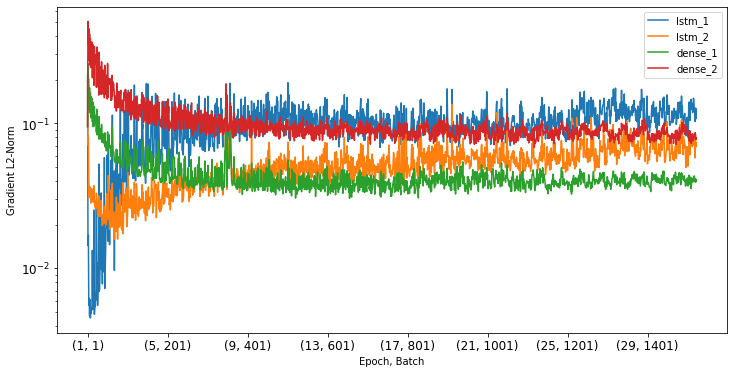

In [20]:
df_grad_norms.plot(figsize = (12, 6), logy = True, xlabel = 'Epoch, Batch', \
             ylabel = 'Gradient L2-Norm', fontsize = 12)

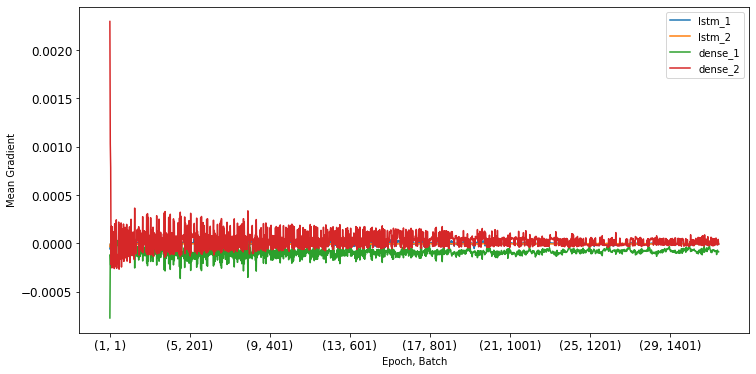

In [21]:
df_grad_means.plot(xlabel = 'Epoch, Batch', \
             ylabel = 'Mean Gradient', figsize = (12, 6), fontsize = 12)

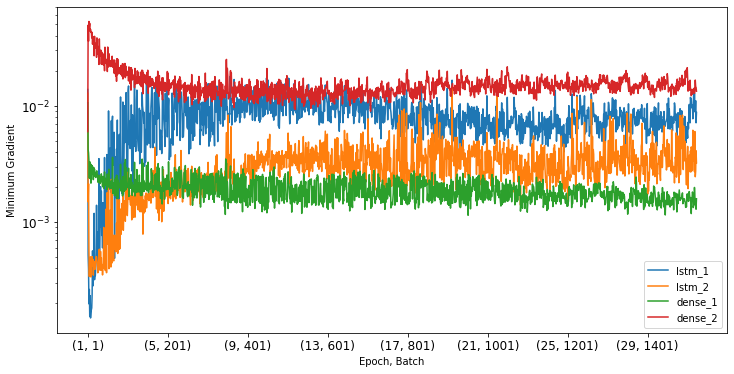

In [22]:
df_grad_minima.abs().plot(xlabel = 'Epoch, Batch', \
             ylabel = 'Minimum Gradient', logy = True, figsize = (12, 6), fontsize = 12)


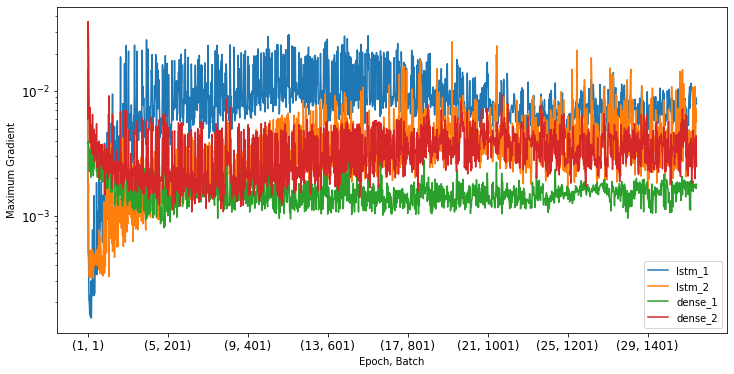

In [23]:
df_grad_maxima.plot(xlabel = 'Epoch, Batch', \
             ylabel = 'Maximum Gradient', logy = True, figsize = (12, 6), fontsize = 12)

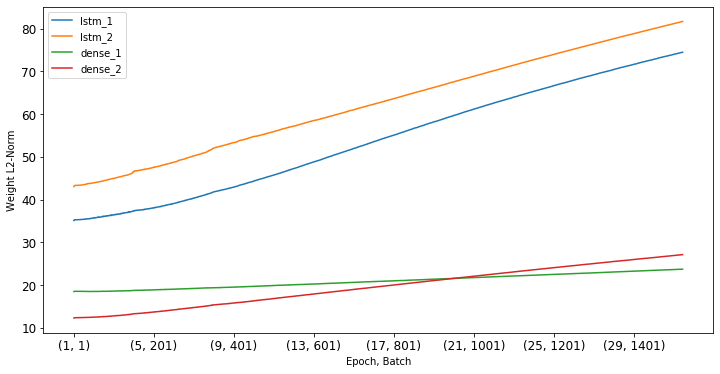

In [24]:
df_weight_norms.plot(figsize = (12, 6), xlabel = 'Epoch, Batch', \
             ylabel = 'Weight L2-Norm', fontsize = 12)

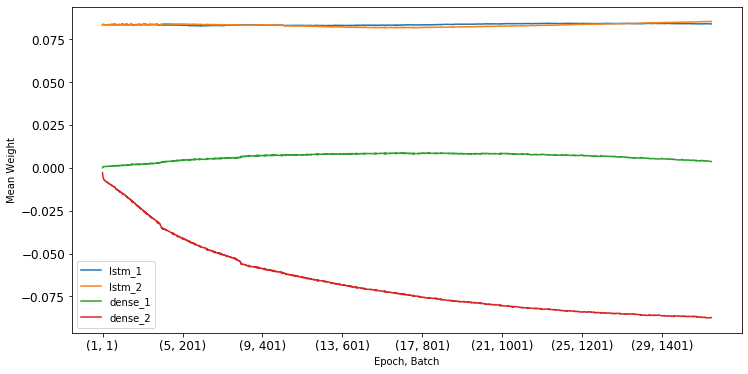

In [26]:
df_weight_means.plot(xlabel = 'Epoch, Batch', \
             ylabel = 'Mean Weight', figsize = (12, 6), fontsize = 12)

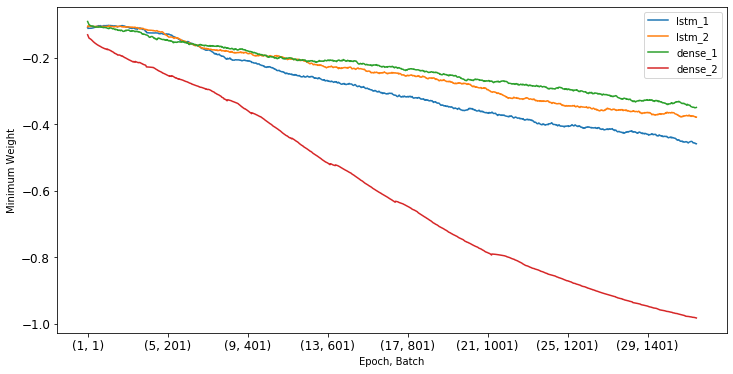

In [27]:
df_weight_minima.plot(xlabel = 'Epoch, Batch', \
             ylabel = 'Minimum Weight',  figsize = (12, 6), fontsize = 12)

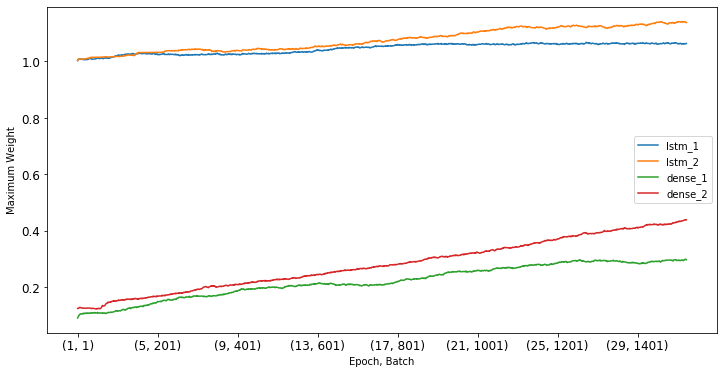

In [251]:
df_weight_maxima.plot(xlabel = 'Epoch, Batch', \
             ylabel = 'Maximum Weight',  figsize = (12, 6), fontsize = 12)

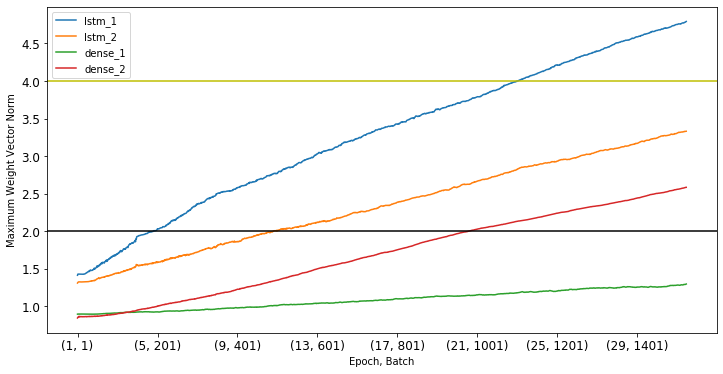

In [28]:
df_max_weight_vector_norms.plot(xlabel = 'Epoch, Batch', \
             ylabel = 'Maximum Weight Vector Norm',  figsize = (12, 6), fontsize = 12)
plt.axhline(4.0, color = 'y')
plt.axhline(2.0, color = 'k')

The above is the important plot for informing our MaxNorm value. The two lines represent the ones tried below.

In [269]:
train_lstm_model(max_norm_value = 4.)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.14278, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4_mnv_4.h5
25307/25307 - 271s - loss: 0.1943 - f1_score_mod: 0.0141 - recall_mod: 0.0216 - precision_mod: 0.0996 - dur_error: 0.5152 - maestro_dur_loss: 0.0258 - val_loss: 0.1428 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.4822 - val_maestro_dur_loss: 0.0241
Epoch 2/150

Epoch 00002: val_loss improved from 0.14278 to 0.12901, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4_mnv_4.h5
25307/25307 - 158s - loss: 0.1455 - f1_score_mod: 0.0094 - recall_mod: 0.0048 - precision_mod: 0.3400 - dur_error: 0.3930 - maestro_dur_loss: 0.0197 - val_loss: 0.1290 - val_f1_score_mod: 0.0180 - val_recall_mod: 0.0091 - val_precision_mod: 0.7154 - val_dur_error: 0.3137 - val_maestro_dur_loss: 0.0157
Epoch 3/150

Epoch 00003: val_loss improved from 0.1

Epoch 20/150

Epoch 00020: val_loss improved from 0.09803 to 0.09584, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4_mnv_4.h5
25307/25307 - 152s - loss: 0.0969 - f1_score_mod: 0.3207 - recall_mod: 0.2056 - precision_mod: 0.7316 - dur_error: 0.2359 - maestro_dur_loss: 0.0118 - val_loss: 0.0958 - val_f1_score_mod: 0.3318 - val_recall_mod: 0.2121 - val_precision_mod: 0.7715 - val_dur_error: 0.2335 - val_maestro_dur_loss: 0.0117
Epoch 21/150

Epoch 00021: val_loss improved from 0.09584 to 0.09426, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4_mnv_4.h5
25307/25307 - 150s - loss: 0.0958 - f1_score_mod: 0.3320 - recall_mod: 0.2148 - precision_mod: 0.7342 - dur_error: 0.2328 - maestro_dur_loss: 0.0116 - val_loss: 0.0943 - val_f1_score_mod: 0.3561 - val_recall_mod: 0.2327 - val_precision_mod: 0.7653 - val_dur_error: 0.2180 - val_maestro_dur_loss: 0.0109
Epoch 22/150

Epoch 00022: val_loss improved from 0.09426 to 0.09349, saving model to ../models/best_maestro

This first attempt with MaxNorm did not really help. We still get a NaN loss while the model is still improving.

In [273]:
train_lstm_model(max_norm_value = 2.)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.14356, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4_mnv_2.h5
25307/25307 - 177s - loss: 0.1963 - f1_score_mod: 0.0168 - recall_mod: 0.0255 - precision_mod: 0.0904 - dur_error: 0.5204 - maestro_dur_loss: 0.0260 - val_loss: 0.1436 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.4191 - val_maestro_dur_loss: 0.0210
Epoch 2/150

Epoch 00002: val_loss improved from 0.14356 to 0.13574, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4_mnv_2.h5
25307/25307 - 146s - loss: 0.1478 - f1_score_mod: 0.0056 - recall_mod: 0.0028 - precision_mod: 0.2507 - dur_error: 0.4182 - maestro_dur_loss: 0.0209 - val_loss: 0.1357 - val_f1_score_mod: 0.0082 - val_recall_mod: 0.0041 - val_precision_mod: 0.7872 - val_dur_error: 0.3879 - val_maestro_dur_loss: 0.0194
Epoch 3/150

Epoch 00003: val_loss improved from 0.1

Epoch 20/150

Epoch 00020: val_loss improved from 0.09625 to 0.09555, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4_mnv_2.h5
25307/25307 - 143s - loss: 0.0971 - f1_score_mod: 0.3156 - recall_mod: 0.2021 - precision_mod: 0.7268 - dur_error: 0.2352 - maestro_dur_loss: 0.0118 - val_loss: 0.0956 - val_f1_score_mod: 0.3522 - val_recall_mod: 0.2330 - val_precision_mod: 0.7269 - val_dur_error: 0.2244 - val_maestro_dur_loss: 0.0112
Epoch 21/150

Epoch 00021: val_loss improved from 0.09555 to 0.09470, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4_mnv_2.h5
25307/25307 - 143s - loss: 0.0959 - f1_score_mod: 0.3305 - recall_mod: 0.2145 - precision_mod: 0.7244 - dur_error: 0.2340 - maestro_dur_loss: 0.0117 - val_loss: 0.0947 - val_f1_score_mod: 0.3505 - val_recall_mod: 0.2302 - val_precision_mod: 0.7356 - val_dur_error: 0.2218 - val_maestro_dur_loss: 0.0111
Epoch 22/150

Epoch 00022: val_loss improved from 0.09470 to 0.09379, saving model to ../models/best_maestro

Epoch 39/150

Epoch 00039: val_loss improved from 0.08490 to 0.08451, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4_mnv_2.h5
25307/25307 - 143s - loss: 0.0756 - f1_score_mod: 0.4980 - recall_mod: 0.3727 - precision_mod: 0.7518 - dur_error: 0.1927 - maestro_dur_loss: 0.0096 - val_loss: 0.0845 - val_f1_score_mod: 0.4794 - val_recall_mod: 0.3566 - val_precision_mod: 0.7322 - val_dur_error: 0.1879 - val_maestro_dur_loss: 0.0094
Epoch 40/150

Epoch 00040: val_loss improved from 0.08451 to 0.08414, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt4_mnv_2.h5
25307/25307 - 143s - loss: 0.0745 - f1_score_mod: 0.5084 - recall_mod: 0.3834 - precision_mod: 0.7557 - dur_error: 0.1904 - maestro_dur_loss: 0.0095 - val_loss: 0.0841 - val_f1_score_mod: 0.4865 - val_recall_mod: 0.3641 - val_precision_mod: 0.7361 - val_dur_error: 0.1895 - val_maestro_dur_loss: 0.0095
Epoch 41/150

Epoch 00041: val_loss improved from 0.08414 to 0.08394, saving model to ../models/best_maestro

Epoch 60/150

Epoch 00060: val_loss did not improve from 0.08279
25307/25307 - 143s - loss: 0.0558 - f1_score_mod: 0.6656 - recall_mod: 0.5751 - precision_mod: 0.7906 - dur_error: 0.1704 - maestro_dur_loss: 0.0085 - val_loss: 0.0858 - val_f1_score_mod: 0.5604 - val_recall_mod: 0.4734 - val_precision_mod: 0.6868 - val_dur_error: 0.1732 - val_maestro_dur_loss: 0.0087
Epoch 61/150

Epoch 00061: val_loss did not improve from 0.08279
25307/25307 - 142s - loss: 0.0548 - f1_score_mod: 0.6709 - recall_mod: 0.5814 - precision_mod: 0.7935 - dur_error: 0.1687 - maestro_dur_loss: 0.0084 - val_loss: 0.0862 - val_f1_score_mod: 0.5693 - val_recall_mod: 0.4885 - val_precision_mod: 0.6823 - val_dur_error: 0.1775 - val_maestro_dur_loss: 0.0089
Epoch 62/150

Epoch 00062: val_loss did not improve from 0.08279
25307/25307 - 142s - loss: 0.0540 - f1_score_mod: 0.6783 - recall_mod: 0.5909 - precision_mod: 0.7964 - dur_error: 0.1670 - maestro_dur_loss: 0.0083 - val_loss: 0.0868 - val_f1_score_mod: 0.5693 - va

Epoch 83/150

Epoch 00083: val_loss did not improve from 0.08279
25307/25307 - 141s - loss: 0.0406 - f1_score_mod: 0.7824 - recall_mod: 0.7301 - precision_mod: 0.8430 - dur_error: 0.1562 - maestro_dur_loss: 0.0078 - val_loss: 0.0973 - val_f1_score_mod: 0.5985 - val_recall_mod: 0.5440 - val_precision_mod: 0.6654 - val_dur_error: 0.1716 - val_maestro_dur_loss: 0.0086
Epoch 84/150

Epoch 00084: val_loss did not improve from 0.08279
25307/25307 - 142s - loss: 0.0403 - f1_score_mod: 0.7854 - recall_mod: 0.7336 - precision_mod: 0.8452 - dur_error: 0.1549 - maestro_dur_loss: 0.0077 - val_loss: 0.0976 - val_f1_score_mod: 0.5961 - val_recall_mod: 0.5396 - val_precision_mod: 0.6661 - val_dur_error: 0.1706 - val_maestro_dur_loss: 0.0085
Epoch 85/150

Epoch 00085: val_loss did not improve from 0.08279
25307/25307 - 144s - loss: 0.0397 - f1_score_mod: 0.7899 - recall_mod: 0.7388 - precision_mod: 0.8488 - dur_error: 0.1534 - maestro_dur_loss: 0.0077 - val_loss: 0.0984 - val_f1_score_mod: 0.5999 - va

Epoch 106/150

Epoch 00106: val_loss did not improve from 0.08279
25307/25307 - 142s - loss: 0.0321 - f1_score_mod: 0.8427 - recall_mod: 0.8087 - precision_mod: 0.8798 - dur_error: 0.1448 - maestro_dur_loss: 0.0072 - val_loss: 0.1100 - val_f1_score_mod: 0.6086 - val_recall_mod: 0.5613 - val_precision_mod: 0.6649 - val_dur_error: 0.1695 - val_maestro_dur_loss: 0.0085
Epoch 107/150

Epoch 00107: val_loss did not improve from 0.08279
25307/25307 - 141s - loss: 0.0320 - f1_score_mod: 0.8448 - recall_mod: 0.8120 - precision_mod: 0.8805 - dur_error: 0.1461 - maestro_dur_loss: 0.0073 - val_loss: 0.1098 - val_f1_score_mod: 0.6114 - val_recall_mod: 0.5662 - val_precision_mod: 0.6646 - val_dur_error: 0.1670 - val_maestro_dur_loss: 0.0083
Epoch 108/150

Epoch 00108: val_loss did not improve from 0.08279
25307/25307 - 141s - loss: 0.0318 - f1_score_mod: 0.8456 - recall_mod: 0.8128 - precision_mod: 0.8813 - dur_error: 0.1455 - maestro_dur_loss: 0.0073 - val_loss: 0.1103 - val_f1_score_mod: 0.6112 -

Wow, we've managed to drastically overfit a model for the first time, thanks to the stabilization provided by MaxNorm. Furthermore, we have our best model yet by quite a margin!

Recall from ./model_training.ipynb that a higher dropout_rate led to earlier failure by NaN Loss, but counteracts overfitting. Now that NaN failure is less of a problem, let's see if increasing the dropout_rate can produce a model that performs better on the validation set.

In [275]:
train_lstm_model(max_norm_value = 2., dropout_rate = 0.5)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.13660, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt5_mnv_2.h5
25307/25307 - 187s - loss: 0.2088 - f1_score_mod: 0.0228 - recall_mod: 0.0346 - precision_mod: 0.0925 - dur_error: 0.5298 - maestro_dur_loss: 0.0265 - val_loss: 0.1366 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.3500 - val_maestro_dur_loss: 0.0175
Epoch 2/150

Epoch 00002: val_loss improved from 0.13660 to 0.13204, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt5_mnv_2.h5
25307/25307 - 237s - loss: 0.1499 - f1_score_mod: 0.0078 - recall_mod: 0.0040 - precision_mod: 0.2524 - dur_error: 0.4067 - maestro_dur_loss: 0.0203 - val_loss: 0.1320 - val_f1_score_mod: 0.0057 - val_recall_mod: 0.0028 - val_precision_mod: 0.6137 - val_dur_error: 0.3318 - val_maestro_dur_loss: 0.0166
Epoch 3/150

Epoch 00003: val_loss improved from 0.1

Epoch 20/150

Epoch 00020: val_loss improved from 0.09979 to 0.09799, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt5_mnv_2.h5
25307/25307 - 192s - loss: 0.1024 - f1_score_mod: 0.2603 - recall_mod: 0.1598 - precision_mod: 0.7080 - dur_error: 0.2443 - maestro_dur_loss: 0.0122 - val_loss: 0.0980 - val_f1_score_mod: 0.2804 - val_recall_mod: 0.1721 - val_precision_mod: 0.7730 - val_dur_error: 0.2210 - val_maestro_dur_loss: 0.0111
Epoch 21/150

Epoch 00021: val_loss improved from 0.09799 to 0.09712, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt5_mnv_2.h5
25307/25307 - 185s - loss: 0.1013 - f1_score_mod: 0.2681 - recall_mod: 0.1656 - precision_mod: 0.7086 - dur_error: 0.2392 - maestro_dur_loss: 0.0120 - val_loss: 0.0971 - val_f1_score_mod: 0.3032 - val_recall_mod: 0.1894 - val_precision_mod: 0.7651 - val_dur_error: 0.2222 - val_maestro_dur_loss: 0.0111
Epoch 22/150

Epoch 00022: val_loss did not improve from 0.09712
25307/25307 - 171s - loss: 0.1003 - f1_scor

Epoch 40/150

Epoch 00040: val_loss did not improve from 0.08746
25307/25307 - 171s - loss: 0.0838 - f1_score_mod: 0.4221 - recall_mod: 0.2971 - precision_mod: 0.7302 - dur_error: 0.2022 - maestro_dur_loss: 0.0101 - val_loss: 0.0875 - val_f1_score_mod: 0.4161 - val_recall_mod: 0.2886 - val_precision_mod: 0.7481 - val_dur_error: 0.1921 - val_maestro_dur_loss: 0.0096
Epoch 41/150

Epoch 00041: val_loss improved from 0.08746 to 0.08678, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt5_mnv_2.h5
25307/25307 - 172s - loss: 0.0830 - f1_score_mod: 0.4287 - recall_mod: 0.3037 - precision_mod: 0.7299 - dur_error: 0.2004 - maestro_dur_loss: 0.0100 - val_loss: 0.0868 - val_f1_score_mod: 0.4359 - val_recall_mod: 0.3096 - val_precision_mod: 0.7383 - val_dur_error: 0.1942 - val_maestro_dur_loss: 0.0097
Epoch 42/150

Epoch 00042: val_loss did not improve from 0.08678
25307/25307 - 174s - loss: 0.0821 - f1_score_mod: 0.4359 - recall_mod: 0.3110 - precision_mod: 0.7301 - dur_error: 0.1994

Epoch 61/150

Epoch 00061: val_loss did not improve from 0.08464
25307/25307 - 172s - loss: 0.0675 - f1_score_mod: 0.5604 - recall_mod: 0.4483 - precision_mod: 0.7481 - dur_error: 0.1816 - maestro_dur_loss: 0.0091 - val_loss: 0.0856 - val_f1_score_mod: 0.5203 - val_recall_mod: 0.4131 - val_precision_mod: 0.7030 - val_dur_error: 0.1821 - val_maestro_dur_loss: 0.0091
Epoch 62/150

Epoch 00062: val_loss did not improve from 0.08464
25307/25307 - 171s - loss: 0.0668 - f1_score_mod: 0.5689 - recall_mod: 0.4586 - precision_mod: 0.7498 - dur_error: 0.1801 - maestro_dur_loss: 0.0090 - val_loss: 0.0855 - val_f1_score_mod: 0.5246 - val_recall_mod: 0.4202 - val_precision_mod: 0.6984 - val_dur_error: 0.1822 - val_maestro_dur_loss: 0.0091
Epoch 63/150

Epoch 00063: val_loss did not improve from 0.08464
25307/25307 - 171s - loss: 0.0661 - f1_score_mod: 0.5746 - recall_mod: 0.4656 - precision_mod: 0.7507 - dur_error: 0.1808 - maestro_dur_loss: 0.0090 - val_loss: 0.0851 - val_f1_score_mod: 0.5235 - va

Epoch 84/150

Epoch 00084: val_loss did not improve from 0.08464
25307/25307 - 170s - loss: 0.0534 - f1_score_mod: 0.6856 - recall_mod: 0.6087 - precision_mod: 0.7850 - dur_error: 0.1688 - maestro_dur_loss: 0.0084 - val_loss: 0.0937 - val_f1_score_mod: 0.5668 - val_recall_mod: 0.4964 - val_precision_mod: 0.6605 - val_dur_error: 0.1749 - val_maestro_dur_loss: 0.0087
Epoch 85/150
Batch 32: Invalid loss, terminating training
16896/25307 - 98s - loss: nan - f1_score_mod: 0.6924 - recall_mod: 0.6163 - precision_mod: 0.7903 - dur_error: 0.1685 - maestro_dur_loss: 0.0084


In [277]:
train_lstm_model(max_norm_value = 2., dropout_rate = 0.5)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.13899, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt5_mnv_2.h5
25307/25307 - 233s - loss: 0.2013 - f1_score_mod: 0.0202 - recall_mod: 0.0275 - precision_mod: 0.0963 - dur_error: 0.5146 - maestro_dur_loss: 0.0257 - val_loss: 0.1390 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.3885 - val_maestro_dur_loss: 0.0194
Epoch 2/150

Epoch 00002: val_loss improved from 0.13899 to 0.13472, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt5_mnv_2.h5
25307/25307 - 176s - loss: 0.1475 - f1_score_mod: 0.0099 - recall_mod: 0.0051 - precision_mod: 0.2915 - dur_error: 0.4006 - maestro_dur_loss: 0.0200 - val_loss: 0.1347 - val_f1_score_mod: 0.0034 - val_recall_mod: 0.0017 - val_precision_mod: 0.7273 - val_dur_error: 0.3123 - val_maestro_dur_loss: 0.0156
Epoch 3/150

Epoch 00003: val_loss improved from 0.1

Epoch 20/150

Epoch 00020: val_loss improved from 0.09853 to 0.09840, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt5_mnv_2.h5
25307/25307 - 172s - loss: 0.1014 - f1_score_mod: 0.2678 - recall_mod: 0.1659 - precision_mod: 0.7001 - dur_error: 0.2411 - maestro_dur_loss: 0.0121 - val_loss: 0.0984 - val_f1_score_mod: 0.3161 - val_recall_mod: 0.2010 - val_precision_mod: 0.7465 - val_dur_error: 0.2368 - val_maestro_dur_loss: 0.0118
Epoch 21/150

Epoch 00021: val_loss improved from 0.09840 to 0.09692, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt5_mnv_2.h5
25307/25307 - 172s - loss: 0.1002 - f1_score_mod: 0.2807 - recall_mod: 0.1752 - precision_mod: 0.7091 - dur_error: 0.2391 - maestro_dur_loss: 0.0120 - val_loss: 0.0969 - val_f1_score_mod: 0.3039 - val_recall_mod: 0.1902 - val_precision_mod: 0.7614 - val_dur_error: 0.2170 - val_maestro_dur_loss: 0.0109
Epoch 22/150

Epoch 00022: val_loss improved from 0.09692 to 0.09647, saving model to ../models/best_maestro

Epoch 39/150

Epoch 00039: val_loss did not improve from 0.08762
25307/25307 - 178s - loss: 0.0822 - f1_score_mod: 0.4383 - recall_mod: 0.3143 - precision_mod: 0.7262 - dur_error: 0.2004 - maestro_dur_loss: 0.0100 - val_loss: 0.0883 - val_f1_score_mod: 0.4315 - val_recall_mod: 0.3055 - val_precision_mod: 0.7368 - val_dur_error: 0.1920 - val_maestro_dur_loss: 0.0096
Epoch 40/150

Epoch 00040: val_loss did not improve from 0.08762
25307/25307 - 172s - loss: 0.0813 - f1_score_mod: 0.4463 - recall_mod: 0.3209 - precision_mod: 0.7344 - dur_error: 0.1992 - maestro_dur_loss: 0.0100 - val_loss: 0.0880 - val_f1_score_mod: 0.4449 - val_recall_mod: 0.3208 - val_precision_mod: 0.7271 - val_dur_error: 0.2003 - val_maestro_dur_loss: 0.0100
Epoch 41/150

Epoch 00041: val_loss improved from 0.08762 to 0.08718, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt5_mnv_2.h5
25307/25307 - 181s - loss: 0.0803 - f1_score_mod: 0.4539 - recall_mod: 0.3295 - precision_mod: 0.7308 - dur_error: 0.1967

Epoch 61/150

Epoch 00061: val_loss did not improve from 0.08549
25307/25307 - 154s - loss: 0.0640 - f1_score_mod: 0.5970 - recall_mod: 0.4921 - precision_mod: 0.7594 - dur_error: 0.1783 - maestro_dur_loss: 0.0089 - val_loss: 0.0869 - val_f1_score_mod: 0.5283 - val_recall_mod: 0.4271 - val_precision_mod: 0.6929 - val_dur_error: 0.1769 - val_maestro_dur_loss: 0.0088
Epoch 62/150

Epoch 00062: val_loss did not improve from 0.08549
25307/25307 - 154s - loss: 0.0634 - f1_score_mod: 0.6001 - recall_mod: 0.4963 - precision_mod: 0.7597 - dur_error: 0.1780 - maestro_dur_loss: 0.0089 - val_loss: 0.0883 - val_f1_score_mod: 0.5316 - val_recall_mod: 0.4375 - val_precision_mod: 0.6783 - val_dur_error: 0.1828 - val_maestro_dur_loss: 0.0091
Epoch 63/150

Epoch 00063: val_loss did not improve from 0.08549
25307/25307 - 159s - loss: 0.0624 - f1_score_mod: 0.6085 - recall_mod: 0.5075 - precision_mod: 0.7601 - dur_error: 0.1764 - maestro_dur_loss: 0.0088 - val_loss: 0.0880 - val_f1_score_mod: 0.5295 - va

Epoch 84/150

Epoch 00084: val_loss did not improve from 0.08549
25307/25307 - 137s - loss: 0.0505 - f1_score_mod: 0.7087 - recall_mod: 0.6371 - precision_mod: 0.7989 - dur_error: 0.1654 - maestro_dur_loss: 0.0083 - val_loss: 0.0972 - val_f1_score_mod: 0.5626 - val_recall_mod: 0.4996 - val_precision_mod: 0.6440 - val_dur_error: 0.1715 - val_maestro_dur_loss: 0.0086
Epoch 85/150

Epoch 00085: val_loss did not improve from 0.08549
25307/25307 - 137s - loss: 0.0501 - f1_score_mod: 0.7126 - recall_mod: 0.6433 - precision_mod: 0.7990 - dur_error: 0.1657 - maestro_dur_loss: 0.0083 - val_loss: 0.0982 - val_f1_score_mod: 0.5745 - val_recall_mod: 0.5118 - val_precision_mod: 0.6548 - val_dur_error: 0.1742 - val_maestro_dur_loss: 0.0087
Epoch 86/150

Epoch 00086: val_loss did not improve from 0.08549
25307/25307 - 137s - loss: 0.0497 - f1_score_mod: 0.7146 - recall_mod: 0.6468 - precision_mod: 0.7984 - dur_error: 0.1659 - maestro_dur_loss: 0.0083 - val_loss: 0.0994 - val_f1_score_mod: 0.5724 - va

In [276]:
train_lstm_model(max_norm_value = 2., dropout_rate = 0.6)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.15065, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt6_mnv_2.h5
25307/25307 - 217s - loss: 0.2164 - f1_score_mod: 0.0260 - recall_mod: 0.0339 - precision_mod: 0.0865 - dur_error: 0.5455 - maestro_dur_loss: 0.0273 - val_loss: 0.1506 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.4884 - val_maestro_dur_loss: 0.0244
Epoch 2/150

Epoch 00002: val_loss improved from 0.15065 to 0.13189, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt6_mnv_2.h5
25307/25307 - 171s - loss: 0.1525 - f1_score_mod: 0.0037 - recall_mod: 0.0019 - precision_mod: 0.1600 - dur_error: 0.4203 - maestro_dur_loss: 0.0210 - val_loss: 0.1319 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.3046 - val_maestro_dur_loss: 0.0152
Epoch 3/150

Epoch 00003: val_loss did n

Epoch 20/150

Epoch 00020: val_loss improved from 0.10173 to 0.10154, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt6_mnv_2.h5
25307/25307 - 172s - loss: 0.1075 - f1_score_mod: 0.1970 - recall_mod: 0.1151 - precision_mod: 0.6919 - dur_error: 0.2485 - maestro_dur_loss: 0.0124 - val_loss: 0.1015 - val_f1_score_mod: 0.2324 - val_recall_mod: 0.1370 - val_precision_mod: 0.7733 - val_dur_error: 0.2273 - val_maestro_dur_loss: 0.0114
Epoch 21/150

Epoch 00021: val_loss improved from 0.10154 to 0.10083, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt6_mnv_2.h5
25307/25307 - 173s - loss: 0.1068 - f1_score_mod: 0.2037 - recall_mod: 0.1197 - precision_mod: 0.6915 - dur_error: 0.2464 - maestro_dur_loss: 0.0123 - val_loss: 0.1008 - val_f1_score_mod: 0.2331 - val_recall_mod: 0.1377 - val_precision_mod: 0.7650 - val_dur_error: 0.2265 - val_maestro_dur_loss: 0.0113
Epoch 22/150

Epoch 00022: val_loss improved from 0.10083 to 0.10007, saving model to ../models/best_maestro

Epoch 40/150

Epoch 00040: val_loss improved from 0.09185 to 0.09185, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt6_mnv_2.h5
25307/25307 - 169s - loss: 0.0933 - f1_score_mod: 0.3222 - recall_mod: 0.2089 - precision_mod: 0.7069 - dur_error: 0.2134 - maestro_dur_loss: 0.0107 - val_loss: 0.0918 - val_f1_score_mod: 0.3449 - val_recall_mod: 0.2227 - val_precision_mod: 0.7732 - val_dur_error: 0.1944 - val_maestro_dur_loss: 0.0097
Epoch 41/150

Epoch 00041: val_loss improved from 0.09185 to 0.09172, saving model to ../models/best_maestro_model_ext20_2_1_512_0pt6_mnv_2.h5
25307/25307 - 170s - loss: 0.0928 - f1_score_mod: 0.3270 - recall_mod: 0.2126 - precision_mod: 0.7116 - dur_error: 0.2123 - maestro_dur_loss: 0.0106 - val_loss: 0.0917 - val_f1_score_mod: 0.3450 - val_recall_mod: 0.2226 - val_precision_mod: 0.7730 - val_dur_error: 0.2002 - val_maestro_dur_loss: 0.0100
Epoch 42/150

Epoch 00042: val_loss improved from 0.09172 to 0.09069, saving model to ../models/best_maestro

Surprisingly, this time increasing the dropout_rate made overfitting worse. Training with larger networks has been done using a GPU on Paperspace [here](https://console.paperspace.com/tedxjaqax/notebook/rlcubrhq4zrvpe). Currently, the best model from there was trained with double the number of nodes as here (1024) is now saved in ../models/best_maestro_model_ext20_2_1_1024_0pt4_mnv_2.h5 (its performance data is saved in ../model_data/performance_data/best_maestro_model_ext20_2_1_1024_0pt4_mnv_2.csv and here are the key validation metrics:

val_precision_mod: 0.7249 - val_dur_error: 0.1658 - val_loss: 0.0782 - val_f1_score_mod: 0.5700 - val_recall_mod: 0.4698